# Siamese Network for Facial Recognition

Facial recognition is different from other image classification problems owing to the fact that we can’t always have a lot of training images for each person in the database. The recognition will have to happen based on a very few (usually one) images of the person added to the database. Such a problem is known as one-shot learning.

One-shot learning is usually facilitated by training a simaese network using triplet loss. Such a network creates an embedding for the image of a face inputted into it wherein the images of the same person’s face results in closer embeddings when compared to images of different faces.

The training is done using triplets of images known as anchor, positive and negative images. The anchor and positive are images of the same person while the negative is an image of a different person. More details are explained in the methodology section.


First let's import the relevant packages.

In [1]:
import os
import cv2
from numpy import asarray
import numpy as np
import glob2
from random import randint

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, Input, Concatenate, concatenate
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
import tensorflow as tf
import keras.backend as K
import tensorflow_addons as tfa

Using TensorFlow backend.


We will use the haar cascades for extracting the face from the images.



In [3]:
face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/ML Resources/Siamese Network/haarcascade_frontalface_default.xml')

Now let's load the database of images from the zip file stored in Google Drive. The dataset contains 10 images each of 10 celebrities (a total of 100 images) from which the triplets would be sampled. 

In [4]:
!unzip '/content/drive/My Drive/ML Resources/Siamese Network/FR Database.zip'

Archive:  /content/drive/My Drive/ML Resources/Siamese Network/FR Database.zip
replace FR Database/Ben Affleck/Ben Affleck_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Now let's define a function to select triplets that are hard or semihard for the network. It also checks for duplicates while sampling.

In [5]:
def create_samples(model_c, n_samples = 100, margin = 1):
  ids = os.listdir('FR Database')

  total = 0
  sample_count = 0
  dup_count = 0

  uids = []

  anchor_semihard_2 = []
  positive_semihard_2 = []
  negative_semihard_2 = []

  last_log = 0

  while sample_count < n_samples:
      duplicate = True
      while duplicate == True:  
        pos_fol = randint(0,9)
        neg_fol = pos_fol
        while (neg_fol == pos_fol):
            neg_fol = randint(0,9)
        p_folder = ids[pos_fol]
        n_folder = ids[neg_fol]
        p_collection = glob2.glob('FR Database/' + p_folder + "/*.jpg")
        n_collection = glob2.glob('FR Database/' + n_folder + "/*.jpg")
        anc_file = randint(0,9)
        pos_file = anc_file
        while (anc_file == pos_file):
            pos_file = randint(0,9)
        neg_file = randint(0,9)
        uid = str(pos_fol) + str(anc_file) + str(pos_file) + str(neg_fol) + str(neg_file)
        if uid in uids:
          dup_count += 1
        else:
          uids.append(uid)
          duplicate = False

      a_file = p_collection[anc_file]
      p_file = p_collection[pos_file]
      n_file = n_collection[neg_file]
      imgs = []
      for count, file in enumerate([a_file, p_file, n_file]):
          img = cv2.imread(file)
          gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
          face = face_cascade.detectMultiScale(gray, 1.1, 5)
          (x, y, w, h) = face[0]
          ROI = img[y:y+h, x:x+w]
          ROI = cv2.resize(ROI, (224,224))
          img = asarray(ROI)
          imgs.append(img)
      imgs = asarray(imgs)

      
      a_embed = preprocess_input(np.reshape(imgs[0], (1,224,224,3)))
      p_embed = preprocess_input(np.reshape(imgs[1], (1,224,224,3)))
      n_embed = preprocess_input(np.reshape(imgs[2], (1,224,224,3)))
      y_pred = model_c.predict([a_embed, p_embed, n_embed])
      length = 128
      a_pred = y_pred[:, 0:length]
      p_pred = y_pred[:, length : 2*length]
      n_pred = y_pred[:, 2* length: ]

      pos_dist = np.linalg.norm((a_pred - p_pred), axis = -1)
      neg_dist = np.linalg.norm((a_pred - n_pred), axis = -1)

      check = False

      if (neg_dist < pos_dist + margin):
        check = True
            
      if (check == True):
        anchor_semihard_2.append(imgs[0])
        positive_semihard_2.append(imgs[1])
        negative_semihard_2.append(imgs[2])
        sample_count +=1
      
      total +=1   

      if (total%500 == 0) and (sample_count/total < 0.01):
        print('Less than 1% of sampled triplets are hard or semihard. Stopping the sampling process!!')
        break 

      if (sample_count%50 == 0) and (sample_count !=last_log):
        print(f'Status - {sample_count} samples in {total} runs. {dup_count} duplicates until now.')
        last_log = sample_count


      
  anchor_semihard_2 = asarray(anchor_semihard_2)
  positive_semihard_2 = asarray(positive_semihard_2)
  negative_semihard_2 = asarray(negative_semihard_2)

  anchor_semihard = preprocess_input(anchor_semihard_2)
  positive_semihard = preprocess_input(positive_semihard_2)
  negative_semihard = preprocess_input(negative_semihard_2)

  return anchor_semihard, positive_semihard, negative_semihard

Now let's define a function to create a base network using VGG16. This will be later used for creating the Siamese network.

In [6]:
def base_network(norm = True):
  base = Sequential()
  base.add(VGG16(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))
  base.add(Dense(units=256,activation='relu'))
  base.add(Dense(units=128,activation=None))
  if norm == True:
    base.add(Lambda(lambda x: tf.math.l2_normalize(x, axis = -1, epsilon=1e-12)))
  base.layers[0].trainable = False
  return base

In [7]:
base = base_network()
base.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
lambda_1 (Lambda)            (None, 128)               0         
Total params: 14,878,912
Trainable params: 164,224
Non-trainable params: 14,714,688
_________________________________________________________________


Now let's define our custom loss function for triplet loss.

In [8]:
def triplet_loss(y_true, y_pred, margin = 1):  
    length = 128
  
    anchor = y_pred[:, 0:length]
    positive = y_pred[:, length : 2*length]
    negative = y_pred[:, 2* length: ]


    pos_dist = K.sqrt(K.sum(K.square(anchor - positive), -1))
    neg_dist = K.sqrt(K.sum(K.square(anchor - negative), -1))

    basic_loss = pos_dist - neg_dist + margin

    loss = K.maximum(basic_loss, 0)

    loss = K.sum(loss)

    return loss

The follwing function creates the siamese network with the three inputs using the base network.

In [9]:
def model(base, lr = 0.001):
  input_1 = Input(shape=(224,224,3))
  input_2 = Input(shape=(224,224,3))
  input_3 = Input(shape=(224,224,3))

  x1 = base(input_1)
  x2 = base(input_2)
  x3 = base(input_3)
  
  out = concatenate([x1, x2, x3], axis=-1)

  model = keras.Model([input_1,input_2,input_3], out)

  model.compile(keras.optimizers.Adam(lr), loss = triplet_loss)
  
  return model

We will also use early stopping so that the learning process stops if there is early convergence. Note that we are using min_delta = 0 for 250 steps. So most probably, there won't be any callback.

In [10]:
from keras.callbacks import EarlyStopping

usualCallback = EarlyStopping(monitor='loss', min_delta=0, patience = 250)

Now let's combine all the earlier functions into a single function call so that the process becomes easier. 

In [11]:
def create_siamese_network(norm = False, lr = 0.001):
  base = base_network(norm)
  model_new = model(base, lr = lr)
  return model_new

In [12]:
face_rec_model = create_siamese_network(norm = True)

We have to define a dummy vector for passing to the model as the true labels vector.

Initially, the model weights would be randomly initiailised and hence most of the samples wouldn't be easy for it. Let's warm up the network by training it on a 500 triplets for 10 epochs.

In [13]:
anchor_semihard,positive_semihard,negative_semihard = create_samples(n_samples = 500, margin = 1, model_c = face_rec_model)
y_dummy = np.empty((anchor_semihard.shape[0],1))
face_rec_model.fit([anchor_semihard, positive_semihard, negative_semihard], y_dummy, batch_size = 50, epochs = 10, callbacks=[usualCallback])

Status - 50 samples in 50 runs. 0 duplicates until now.
Status - 100 samples in 100 runs. 0 duplicates until now.
Status - 150 samples in 150 runs. 0 duplicates until now.
Status - 200 samples in 200 runs. 0 duplicates until now.
Status - 250 samples in 250 runs. 0 duplicates until now.
Status - 300 samples in 300 runs. 0 duplicates until now.
Status - 350 samples in 350 runs. 0 duplicates until now.
Status - 400 samples in 400 runs. 0 duplicates until now.
Status - 450 samples in 450 runs. 1 duplicates until now.
Status - 500 samples in 500 runs. 1 duplicates until now.
Epoch 1/10
500/500 [==============================] - 21s 41ms/step - loss: 39.9474
Epoch 2/10
500/500 [==============================] - 16s 32ms/step - loss: 21.2148
Epoch 3/10
500/500 [==============================] - 16s 32ms/step - loss: 12.1085
Epoch 4/10
500/500 [==============================] - 16s 32ms/step - loss: 6.6616
Epoch 5/10
500/500 [==============================] - 16s 32ms/step - loss: 3.6215
Epoc

Now let's mine for hard and semi hard triplets and then train the network for longer.

In [14]:
anchor_semihard,positive_semihard,negative_semihard = create_samples(n_samples = 2000, margin = 1, model_c = face_rec_model)
y_dummy = np.empty((anchor_semihard.shape[0],1))
face_rec_model.fit([anchor_semihard, positive_semihard, negative_semihard], y_dummy, batch_size = 128, epochs = 20, callbacks=[usualCallback])

Status - 50 samples in 139 runs. 0 duplicates until now.
Status - 100 samples in 295 runs. 0 duplicates until now.
Status - 150 samples in 491 runs. 3 duplicates until now.
Status - 200 samples in 654 runs. 6 duplicates until now.
Status - 250 samples in 808 runs. 7 duplicates until now.
Status - 300 samples in 976 runs. 9 duplicates until now.
Status - 350 samples in 1139 runs. 13 duplicates until now.
Status - 400 samples in 1303 runs. 17 duplicates until now.
Status - 450 samples in 1467 runs. 19 duplicates until now.
Status - 500 samples in 1608 runs. 23 duplicates until now.
Status - 550 samples in 1756 runs. 23 duplicates until now.
Status - 600 samples in 1894 runs. 29 duplicates until now.
Status - 650 samples in 2061 runs. 32 duplicates until now.
Status - 700 samples in 2225 runs. 34 duplicates until now.
Status - 750 samples in 2374 runs. 36 duplicates until now.
Status - 800 samples in 2537 runs. 44 duplicates until now.
Status - 850 samples in 2692 runs. 49 duplicates unti

In [15]:
anchor_semihard,positive_semihard,negative_semihard = create_samples(n_samples = 500, margin = 1, model_c = face_rec_model)

Less than 1% of sampled triplets are hard or semihard. Stopping the sampling process!!


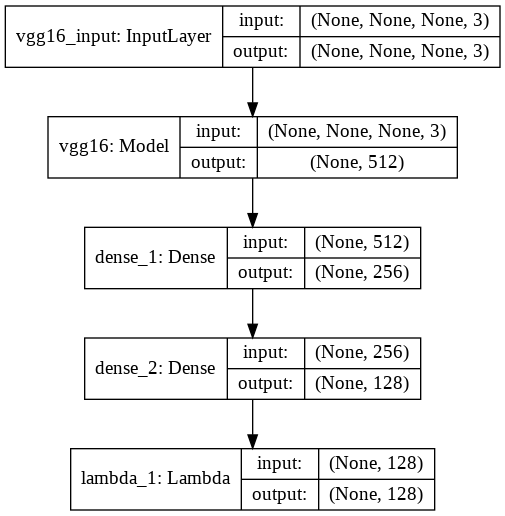

In [19]:
from keras.utils.vis_utils import plot_model
plot_model(base, to_file='model_plot.png', show_shapes=True, show_layer_names=True)